In [1]:
# References:
# https://www.kaggle.com/code/jhoward/linear-model-and-neural-net-from-scratch
# https://github.com/teyang-lau/HDB_Resale_Prices
# https://nbviewer.org/github/teyang-lau/HDB_Resale_Prices/blob/main/flat_prices.ipynb
# https://colab.research.google.com/github/fastai/fastbook/blob/master/09_tabular.ipynb
# https://docs.fast.ai/tutorial.tabular.html

# Data from Data.gov.sg
# https://beta.data.gov.sg/datasets/d_8b84c4ee58e3cfc0ece0d773c8ca6abc/view

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# load data

In [4]:
price2017 = pd.read_csv('resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv')

In [5]:
# check data

In [6]:
price2017.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0


In [7]:
df = price2017.copy()
df.month.unique() # 2017-01 to 2020-09
df.town.unique()
df.resale_price.head()
df.flat_type.unique()
df.block.unique()
df.street_name.unique()
df.storey_range.unique()
df.floor_area_sqm.unique()
df.flat_model.unique()
df.lease_commence_date.unique() # remaining_lease (No. of years remaining) is more relevant to price
df.remaining_lease.unique() 
df.resale_price.unique()

array([232000., 250000., 262000., ..., 358500., 671300., 459988.])

In [8]:
df.describe(include='all')

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
count,80374,80374,80374,80374,80374,80374,80374.000000,80374,80374.000000,80374,8.037400e+04
unique,45,26,7,2446,548,17,NaN,20,NaN,623,NaN
top,2018-07,SENGKANG,4 ROOM,2,YISHUN RING RD,04 TO 06,NaN,Model A,NaN,94 years 11 months,NaN
freq,2539,6408,33282,273,1245,18697,NaN,26288,NaN,615,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,97.617804,NaN,1994.117501,NaN,4.393165e+05
std,NaN,NaN,NaN,NaN,NaN,NaN,24.285811,NaN,12.839267,NaN,1.533902e+05
min,NaN,NaN,NaN,NaN,NaN,NaN,31.000000,NaN,1966.000000,NaN,1.400000e+05
25%,NaN,NaN,NaN,NaN,NaN,NaN,82.000000,NaN,1984.000000,NaN,3.300000e+05
50%,NaN,NaN,NaN,NaN,NaN,NaN,95.000000,NaN,1994.000000,NaN,4.100000e+05
75%,NaN,NaN,NaN,NaN,NaN,NaN,113.000000,NaN,2003.000000,NaN,5.150000e+05


In [9]:
# check missing values

In [10]:
price2017.isna().sum()

month                  0
town                   0
flat_type              0
block                  0
street_name            0
storey_range           0
floor_area_sqm         0
flat_model             0
lease_commence_date    0
remaining_lease        0
resale_price           0
dtype: int64

In [11]:
# Exploratory Data Analysis
# all the columns are intuitively related to final price
# some other factors: 
# 1. location related to MRT, school, super market, Expressway, Distance to city center, food court, park, etc
# => can be inferred by feature embedding for 'street_name'
# 2. inflation/CPI/Property price index
# => can be inferred by feature embedding for 'resale_price' and 'month'
# 3. Economic conditions, employment data, mortgage rate/interest rate, income level, etc
# => can be inferred by feature embedding for 'resale_price' and 'month'
# 4. same block may have different facing, view, noise, renovation, etc. 
# => Unknown variable.

# changes:
# 1. drop lease_commence_date
# 2. convert remaining_lease to remaining_lease_ (years of lease left)
# 3. block is different meaning in different street. "street + block" is more meaningful. 
# =>Add "address", drop "block"
# => street is also kept.
# 4. change "month" to "month_" ordinal category.
# 5. change resale_price to log.

In [12]:
train_price_mean = 0
train_price_std = 1
def prepare_input():
    df['remaining_lease_'] = df.remaining_lease.apply(lambda x: int(str(x).replace("years","").replace("months","").split()[0]))
    df['address'] = df['street_name'] + " BLK " + df['block']
    df['month_'] = df['month'].astype('category')
    df['resale_price_'] = np.log(df['resale_price'])
    # normalize price
    train_price_mean = df['resale_price_'].mean()
    df['resale_price_'] = df['resale_price_'] - train_price_mean
    train_price_std = df['resale_price_'].std()
    df['resale_price_'] = df['resale_price_'] / train_price_std
    return train_price_mean, train_price_std

In [13]:
train_price_mean, train_price_std = prepare_input()

In [14]:
df['remaining_lease_'].head()

0    61
1    60
2    62
3    62
4    62
Name: remaining_lease_, dtype: int64

In [15]:
df[['block','street_name']].head()

,block,street_name
0,406,ANG MO KIO AVE 10
1,108,ANG MO KIO AVE 4
2,602,ANG MO KIO AVE 5
3,465,ANG MO KIO AVE 10
4,601,ANG MO KIO AVE 5


In [16]:
df['address'].head()

0    ANG MO KIO AVE 10 BLK 406
1     ANG MO KIO AVE 4 BLK 108
2     ANG MO KIO AVE 5 BLK 602
3    ANG MO KIO AVE 10 BLK 465
4     ANG MO KIO AVE 5 BLK 601
Name: address, dtype: object

In [17]:
df['month'].head()

0    2017-01
1    2017-01
2    2017-01
3    2017-01
4    2017-01
Name: month, dtype: object

In [18]:
df['month'].unique()

array(['2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06',
       '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12',
       '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06',
       '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12',
       '2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06',
       '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12',
       '2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06',
       '2020-07', '2020-08', '2020-09'], dtype=object)

In [19]:
df['month_'].unique()

['2017-01', '2017-02', '2017-03', '2017-04', '2017-05', ..., '2020-05', '2020-06', '2020-07', '2020-08', '2020-09']
Length: 45
Categories (45, object): ['2017-01', '2017-02', '2017-03', '2017-04', ..., '2020-06', '2020-07', '2020-08', '2020-09']

In [20]:
def restore_price(p):
    p *= train_price_std
    p += train_price_mean
    return np.exp(p)

In [21]:
restore_price(-1.773979)

232000.0371859293

In [22]:
df[['resale_price_', 'resale_price']].head()

,resale_price_,resale_price
0,-1.773979,232000.0
1,-1.546616,250000.0
2,-1.403961,262000.0
3,-1.369319,265000.0
4,-1.369319,265000.0


In [23]:
# 1st Model with Deep Learning (fastai's tabular library)

In [24]:
from fastai.tabular.all import *

In [25]:
df.columns

Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date',
       'remaining_lease', 'resale_price', 'remaining_lease_', 'address',
       'month_', 'resale_price_'],
      dtype='object')

In [26]:
#splits = RandomSplitter(valid_pct=0.2)(range_of(df))
splits = EndSplitter(valid_last=True)(range_of(df))

In [27]:
min(splits[1]), max(splits[1])

(64300, 80373)

In [28]:
min(splits[0]), max(splits[0])

(0, 64299)

In [29]:
to = TabularPandas(df, procs=[Categorify, FillMissing,Normalize],
                   cat_names = ['flat_model', 'storey_range', 'street_name', 'address', 'flat_type', 'town', 'month_'],
                   cont_names = ['remaining_lease_', 'floor_area_sqm'],
                   y_names='resale_price_',
                   splits=splits)

In [30]:
to.xs.iloc[-2:-1]

,flat_model,storey_range,street_name,address,flat_type,town,month_,remaining_lease_,floor_area_sqm
80372,7,2,520,8309,6,26,45,-0.647591,1.988954


In [31]:
dls = to.dataloaders(bs=64)

In [32]:
y = to.train.y

In [33]:
y.min(),y.max()

(-3.1009223, 3.238918)

In [34]:
def train_again():
    #dls.show_batch()
    learn = tabular_learner(dls, metrics=exp_rmspe)
    learn.fit_one_cycle(8)
    learn.show_results()
    learn.save("model_1a_8epochs")
    learn.export("export.pkl")

In [35]:
learn = tabular_learner(dls, metrics=exp_rmspe)
learn.load("model_1a_7epochs")

In [36]:
idx = -100

In [37]:
inp_ = df.iloc[idx]
inp = df[['flat_model', 'storey_range', 'street_name', 'address', 'flat_type', 'town', 'month_', 'remaining_lease_', 'floor_area_sqm']].iloc[idx]

In [38]:
row, clas, probs = learn.predict(inp)
#df[['flat_model', 'storey_range', 'street_name', 'address', 'flat_type', 'town', 'month_', 'remaining_lease_', 'floor_area_sqm']]
row.show()
clas, probs

,flat_model,storey_range,street_name,address,flat_type,town,month_,remaining_lease_,floor_area_sqm,resale_price_
0,Model A,04 TO 06,YISHUN AVE 9,YISHUN AVE 9 BLK 315C,4 ROOM,YISHUN,2020-09,94.0,92.0,-0.090952


(tensor([-0.0910]), tensor([-0.0910]))

In [39]:
price2017.iloc[idx]

month                             2020-09
town                               YISHUN
flat_type                          4 ROOM
block                                315C
street_name                  YISHUN AVE 9
storey_range                     04 TO 06
floor_area_sqm                       92.0
flat_model                        Model A
lease_commence_date                  2015
remaining_lease        94 years 02 months
resale_price                     423000.0
Name: 80274, dtype: object

In [40]:
(inp_['resale_price_']), row['resale_price_'].iloc[0]

(0.053592774653086754, -0.09095153212547302)

In [41]:
restore_price(inp_['resale_price_']), restore_price(row['resale_price_'].iloc[0])

(422999.9999999997, 403375.3188587308)

In [42]:
(restore_price(inp_['resale_price_']) - restore_price(row['resale_price_'].iloc[0]))/restore_price(inp_['resale_price_'])

0.04639404525122681

In [43]:
def update_validation_date():
    df_pred = df.copy()
    
    # use last trained date as validation date
    lastdate = df_pred.iloc[max(splits[0])].month
    df_pred.loc[splits[1],'month'] = lastdate
    df_pred.iloc[splits[1]]
    df.iloc[splits[1]]

In [44]:
inp_cols = ['flat_model', 'storey_range', 'street_name', 'address', 'flat_type', 'town', 'month_', 'remaining_lease_', 'floor_area_sqm']
uniques = {}
modes = {}
for c in inp_cols:
    uniques[c] = df.iloc[splits[0]][c].unique()
    modes[c] = df.iloc[splits[0]][c].mode()[0]


In [45]:
def get_rpi(year, month):
    quarters = ['Q1']*3 + ['Q2']*3 + ['Q3']*3 + ['Q4']*3 
    months = list(range(1,13))
    quarter = quarters[months.index(month)]
    quarter = str(year) + '-' + quarter
    rpi = df_rpi[df_rpi.quarter==quarter]['index']
    #print(rpi)
    #print(rpi.loc[4])
    return  float(rpi.iloc[0] if len(rpi) > 0 else 0)

# Get scale factor from rpi
def get_rpi_ym(year_month):
    y = int(year_month[0:4])
    m = int(year_month[5:7])
    return get_rpi(y,m)
        
def get_rpi_factor(year_month):
    #print("getting..." + year_month)
    if year_month in uniques['month_']:
        # within training period
        return 1
    else:
        predicted_ym = uniques['month_'][-1]
        predicted_ym_rpi = get_rpi_ym(predicted_ym) 
        #print(predicted_ym_rpi)
        #print(get_rpi_ym(year_month))
        #return 1 - (predicted_ym_rpi - get_rpi_ym(year_month) )/predicted_ym_rpi
        actual_ym_rpi = get_rpi_ym(year_month)
        #print(actual_ym_rpi)
        return actual_ym_rpi/predicted_ym_rpi if actual_ym_rpi != 0 else 1        
        #return (get_rpi_ym(year_month))/predicted_ym_rpi

In [46]:
def update_inp_with_trained_cat(idx = 0):
    inp_ = df.iloc[idx]
    inp = inp_[inp_cols]
    updated = False
    skipped = False
    for c in inp.keys():
        if (type(inp[c]) == str):
            if not inp[c] in uniques[c]:
                inp = inp.copy()
                # find mode of column c
                updated = True
                if c == 'month_':
                    lastdate = df.iloc[max(splits[0])].month
                    inp[c] = lastdate     
                else:
                    inp[c] = ''
                    skipped = True
    # add rpi factor
    inp['rpi_factor'] = get_rpi_factor(df.iloc[idx]['month_'])
    return inp_, inp, updated, skipped

for i in splits[1][:100]:
    i1, i2, updated, skipped = update_inp_with_trained_cat(i)

In [47]:
df_new_data = pd.read_csv("ResaleflatpricesbasedonregistrationdatefromJan2017onwards.csv")

In [48]:
inp_cols

['flat_model',
 'storey_range',
 'street_name',
 'address',
 'flat_type',
 'town',
 'month_',
 'remaining_lease_',
 'floor_area_sqm']

In [49]:
inp_.keys

<bound method Series.keys of month                                2020-09
town                                  YISHUN
flat_type                             4 ROOM
block                                   315C
street_name                     YISHUN AVE 9
storey_range                        04 TO 06
floor_area_sqm                          92.0
flat_model                           Model A
lease_commence_date                     2015
remaining_lease           94 years 02 months
resale_price                        423000.0
remaining_lease_                          94
address                YISHUN AVE 9 BLK 315C
month_                               2020-09
resale_price_                       0.053593
Name: 80274, dtype: object>

In [50]:
idx = 0
inp_ = df_new_data.iloc[idx].copy()
inp_['address'] = inp_['street_name'] + " BLK " + inp_['block']
inp_['month_'] = inp_['month']
inp_['resale_price_'] = np.log(inp_['resale_price'])
inp_['remaining_lease_'] = inp_['remaining_lease'].replace("years","").replace("months","").split()[0]

inp = inp_[inp_cols]
inp

flat_model                           Improved
storey_range                         10 TO 12
street_name                 ANG MO KIO AVE 10
address             ANG MO KIO AVE 10 BLK 406
flat_type                              2 ROOM
town                               ANG MO KIO
month_                                2017-01
remaining_lease_                           61
floor_area_sqm                           44.0
Name: 0, dtype: object

In [51]:
def update_inp_with_trained_cat_new_data(idx = 0):
    inp_ = df_new_data.iloc[idx].copy()
    inp_['address'] = inp_['street_name'] + " BLK " + inp_['block']
    inp_['month_'] = inp_['month']
    inp_['resale_price_'] = np.log(inp_['resale_price'])
    inp_['remaining_lease_'] = int(inp_['remaining_lease'].replace("years","").replace("months","").split()[0])
    
    inp = inp_[inp_cols]
    # add rpi factor
    inp['rpi_factor'] = get_rpi_factor(inp_['month_'])

    updated = False
    skipped = False
    for c in inp.keys():
        if (type(inp[c]) == str):
            #print(c)
            if not inp[c] in uniques[c]:
                inp = inp.copy()
                # find mode of column c
                updated = True
                if c == 'month_':
                    lastdate = df.iloc[max(splits[0])].month
                    inp[c] = lastdate     
                else:
                    inp[c] = ''
                    skipped = True

    return inp_, inp, updated, skipped

In [52]:
#update_inp_with_trained_cat_new_data(176472)

In [53]:
def predict_new_data(idx=0, p=False, price_scaler = 1):
    inp_, inp, updated, skipped = update_inp_with_trained_cat_new_data(idx)
    if skipped: return idx, 1

    price_scaler = inp['rpi_factor']
    #print("price_scaler:" + str(price_scaler))
    #print(inp)
    row, clas, probs = learn.predict(inp)
    #y = restore_price(inp_['resale_price_'])
    y = inp_['resale_price']
    pred = restore_price(row['resale_price_'].iloc[0]) * price_scaler
    if p: print(f'idx: {idx}, y: {y}, pred: {pred}')
    err = (restore_price(inp_['resale_price_']) - pred)/restore_price(inp_['resale_price_'])
    if p: print(f'err: {err}')
    return idx, err, y, pred

In [54]:
def predict(idx=0, p=False, price_scaler = 1):
    inp_, inp, updated, skipped = update_inp_with_trained_cat(idx)
    if skipped: return idx, 1

    price_scaler = inp['rpi_factor']
    #print(price_scaler)
        
    row, clas, probs = learn.predict(inp)
    y = restore_price(inp_['resale_price_'])
    pred = restore_price(row['resale_price_'].iloc[0]) * price_scaler
    if p: print(f'idx: {idx}, y: {y}, pred: {pred}')
    err = (restore_price(inp_['resale_price_']) - pred)/restore_price(inp_['resale_price_'])
    if p: print(f'err: {err}')
    return idx, err, y, pred
    

In [55]:
df.iloc[splits[1]]['month'].unique().sort()

In [56]:
r = splits[0][0:1000]
r = list(df.iloc[r][df.iloc[r].remaining_lease_>70].index)

In [57]:
# HDB resale price index from https://beta.data.gov.sg/collections/152/datasets/d_14f63e595975691e7c24a27ae4c07c79/view
# and from https://www.hdb.gov.sg/residential/selling-a-flat/overview/resale-statistics
df_rpi = pd.read_csv('HousingAndDevelopmentBoardResalePriceIndex1Q2009100Quarterly.csv')

In [58]:
df_rpi.head()

,quarter,index
0,1990-Q1,24.3
1,1990-Q2,24.4
2,1990-Q3,25.0
3,1990-Q4,24.7
4,1991-Q1,24.9


In [59]:
get_rpi(1991,1)

24.9

In [60]:
uniques['month_'][-1]
get_rpi_ym('2020-01')
get_rpi_ym('1991-01')
131.5*get_rpi_factor('2020-09')
#131.5 * (1-0.8106463878326996)

133.9

In [61]:
# evaluate the mean absolute error of prediction
def evaluate(r):
    s = []
    for idx in r:
        inp_, inp, updated, skipped = update_inp_with_trained_cat(idx)
        if not skipped: s += [idx]
    r = s
    #print('len:' + str(len(r)))
    
    idx, res, y, pred = zip(*[predict(i) for i in r])
    y, pred = tensor(y), tensor(pred)
    plt.plot(r, (y - pred).abs())
    res = tensor(res)
    print(f'Mean absolute error is: {(y - pred).abs().mean()}')


Mean absolute error is: 14213.7255859375


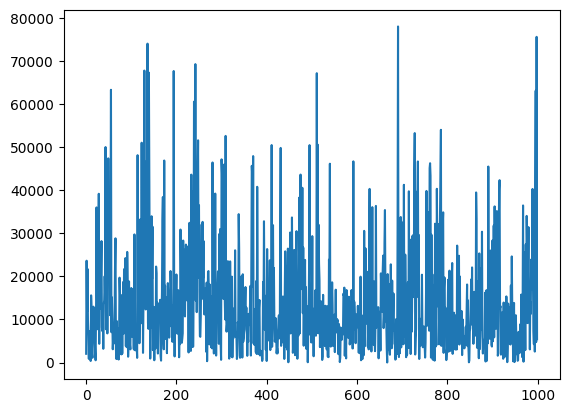

In [62]:
r = splits[0][0:1000] # evaluate with HDB data in the training period. The mean absolute error is S$14k.
evaluate(r)

Mean absolute error is: 20683.771484375


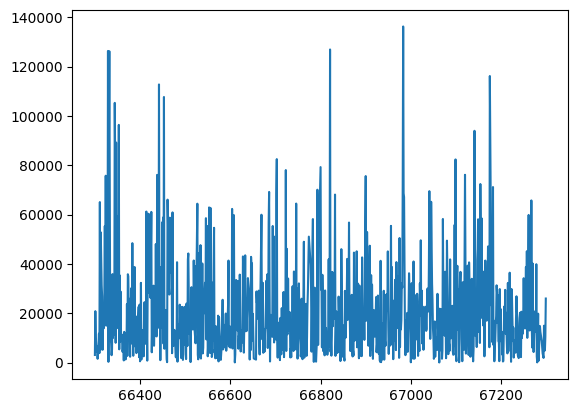

In [63]:
r = splits[1][2000:3000] # evaluate with HDB data after the training period. The mean absolute error is S$20k.
evaluate(r)

In [64]:
def evaluate_new_data(r):
    s = []
    for idx in r:
        inp_, inp, updated, skipped = update_inp_with_trained_cat_new_data(idx)
        if not skipped: s += [idx]
    r = s
    print('len:' + str(len(r)))
    
    idx, res, y, pred = zip(*[predict_new_data(i) for i in r])
    y, pred = tensor(y), tensor(pred)
    #plt.plot(r,res)
    plt.plot(r, (y - pred).abs())
    res = tensor(res)
    print(f'Mean absolute error is: {(y - pred).abs().mean()}')

In [65]:
r = list(range(len(df_new_data)))
df_new_data.iloc[r[-1000]]

month                             2024-03
town                             TAMPINES
flat_type                          3 ROOM
block                                 801
street_name                TAMPINES AVE 4
storey_range                     01 TO 03
floor_area_sqm                       68.0
flat_model                 New Generation
lease_commence_date                  1984
remaining_lease        59 years 05 months
resale_price                     423000.0
Name: 175487, dtype: object

len:770


Mean absolute error is: 36954.05078125


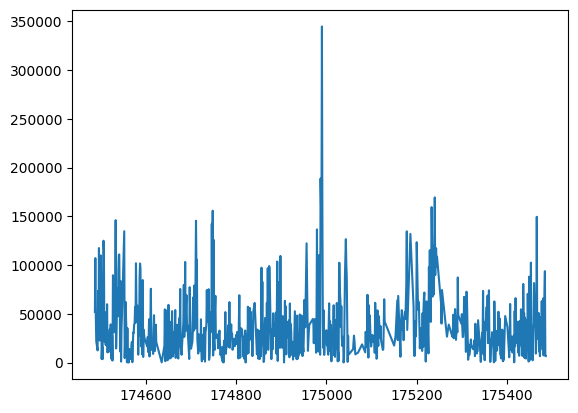

In [66]:
# The same model (trained with data before 2020-01) can still be used to predict 2024-03 HDB price. 
# Resale price index is used to adjust for inflation.
# Since many new variables are not known to the model, such as regional differences, new MRT, shopping mall, school, etc, 
# the predicted price has a bit higher mean absolute error of S$37k. 
r = list(range(len(df_new_data)))
r = r[-2000:-1000]
evaluate_new_data(r) 